## Import

In [ ]:
# Import of basic packages
import numpy as np
import pandas as pd
import operator
from joblib import dump, load
import sys
import warnings

warnings.filterwarnings('ignore')

# Import of chart packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import altair as alt

# Import for normal distribution
import pylab
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro

# Import of machine learning metric packages
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix, mean_squared_error, r2_score, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, fbeta_score
from sklearn import metrics
from scipy.stats import randint, uniform, loguniform

# Import of preprossesor packages
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, LabelBinarizer, PolynomialFeatures

# Import of machine learning packages
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier, RandomForestRegressor, VotingClassifier, StackingRegressor, StackingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Set random seed 
RSEED = 0

## Style

In [ ]:
pd.set_option('display.max_columns', None)

## Load

In [ ]:
# Load csv
df = pd.read_csv('data/train.csv')
df.head(3)

## Explore data analysis

In [ ]:
# EDA info & describe
info = pd.concat([
df.dtypes.to_frame().T,
df.mean(numeric_only=True).to_frame().T,
df.std(numeric_only=True).to_frame().T,
df.min(numeric_only=True).to_frame().T,
df.quantile(0.25, numeric_only=True).to_frame().T,
df.quantile(0.5, numeric_only=True).to_frame().T, 
df.quantile(0.75, numeric_only=True).to_frame().T,
df.max(numeric_only=True).to_frame().T,], ignore_index=True).applymap(lambda x: round(x, 1) if isinstance(x, (int, float)) else x)

info.insert(0, 'statistic', ['dtype', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
info

In [ ]:
# EDA duplicates
duplicates = df.duplicated().sum()
duplicate_percentage = round((duplicates / df.shape[0]) * 100, 1)
df[df.duplicated(keep=False)].head(10)

In [ ]:
# EDA NaNs
missing = pd.DataFrame(df.isnull().sum(), columns=['Amount'])
missing['Percentage'] = round((missing['Amount']/df.shape[0]) * 100, 1)
missing[missing['Amount'] != 0]

In [ ]:
# EDA shape
print('Number of rows and columns: ',df.shape)
print('-'*50)
pd.concat([df.head(3), df.tail(3)]).reset_index(drop=True)

In [ ]:
# EDA Uniques
unique_counts = pd.DataFrame(df.nunique(), columns=['Amount']).sort_values('Amount', ascending=False).T
unique_counts

In [ ]:
df.head(10)

In [ ]:
# Get dataframe for delayed flights
df_delayed = df.copy()
df_delayed = df_delayed[df_delayed["target"] > 0]
df_delayed.info()

In [ ]:
# Overview of target distribution
print("General statistics of target:\n", (df['target']).describe())

# Creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Assigning a graph to each ax
sns.boxplot(df["target"], orient="h", ax=ax_box, color='lightblue')
sns.histplot(data=df, x="target", ax=ax_hist, color='lightblue')

# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set_xlim([-20, 500])
plt.show()

In [ ]:
# Overview of target distribution (of delayed flights)
print("General statistics of target (of delayed flights):\n", (df_delayed['target']).describe())

# Creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Assigning a graph to each ax
sns.boxplot(df_delayed["target"], orient="h", ax=ax_box, color='lightblue')
sns.histplot(data=df_delayed, x="target", ax=ax_hist, color='lightblue')

# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set_xlim([-20, 500])
plt.show()

In [ ]:
stat, p = shapiro(df_delayed['target'])

# Interpretation of p-value
alpha = 0.05
if p > alpha:
    print('The data of column "target" looks normally distributed (p > 0.05, fail to reject H0).')
else:
    print('The data of column "target" does not look normally distributed (p < 0.05, reject H0).')

In [ ]:
# Grafic methode: Q-Q-Plot
stats.probplot(df_delayed['target'], dist="norm", plot=pylab)
pylab.show()

Check influence of departure and arrival airport route

In [ ]:
df['flight_route'] = df["DEPSTN"] + df["ARRSTN"]

In [ ]:
# Get 5 most frequent flight routes
df['flight_route'].value_counts(sort=True).head(5)

In [ ]:
df[df["flight_route"]=="TUNTUN"].head(5)

In [ ]:
# Get all entries, where dep and arr airport are the same
df[df["DEPSTN"]==df["ARRSTN"]].shape

In [ ]:
# Start with a basic boxplot
sns.boxplot(x="flight_route", y="target", data=df[(df['flight_route']=="TUNORY") | (df['flight_route']=="ORYTUN") | (df['flight_route']=="TUNTUN")])

# add title
plt.title("Flight delay time for 3 most frequent flight routes")
plt.ylim(-5, 140)

# show the graph
plt.show()

In [ ]:
# Get top 5 flight routes with most delay time
top_categories = df.groupby('flight_route')['target'].sum().nlargest(5)

print(top_categories)

In [ ]:
print("ORYTUN contribution to total delay time in %: ", round((487348/df["target"].sum())*100, 2))

In [ ]:
# Start with a basic boxplot
sns.boxplot(x="flight_route", y="target", data=df[(df['flight_route']=="ORYTUN") | (df['flight_route']=="TUNORY") | (df['flight_route']=="ISTTUN")])

# add title
plt.title("Top 3 flight routes with most delay time")
plt.ylim(-5, 140)

# show the graph
plt.show()

In [ ]:
df = df.drop("flight_route", axis=1)

## Data cleaning

In [ ]:
# Clean column names
df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns.str.lower()

Feature 'ac' holds information about the model of the airplane. Extracting and converting the information.

In [ ]:
df['airplane_model'] = df['ac'].str[3:6]
df.head()

In [ ]:
# EDA Uniques
unique_counts = pd.DataFrame(df.nunique(), columns=['Amount']).sort_values('Amount', ascending=False).T
unique_counts

In [ ]:
set(df['airplane_model'])

In [ ]:
replacement_dict = {
    '31A': 'Airbus',
    '31B': 'Airbus',
    '320': 'Airbus',
    '321': 'Airbus',
    '32A': 'Airbus',
    '332': 'Airbus',
    '343': 'Airbus',
    '345': 'Airbus',
    '733': 'Boeing',
    '734': 'Boeing',
    '736': 'Boeing',
    'AT7': 'ATR',
    'CR9': 'Bombardier'
}

df['producer'] = df['airplane_model']

# Replace values in the 'purpose' column
df['producer'] = df['producer'].replace(replacement_dict)


In [ ]:
df.head()

In [ ]:
df['airline_1'] = df['fltid'].str[0:2]
df.head()

In [ ]:
set(df['airline_1'])

In [ ]:
df['airline_2'] = df['ac'].str[0:2]
df.head()

In [ ]:
set(df['airline_2'])

In [ ]:
df.head()

Load airpots data set and clean. 

Merge data sets based on airport short handle. 

In [ ]:
# Add columns with weekdays, yyyy, mm, dd, hh:mm:ss

y = '_year'
m = '_month'
wd = '_wd'
M = '_min'

### std ###

date = 'std'

idx = df.columns.get_loc(date)

df[date] = pd.to_datetime(df[date], format='%Y-%m-%d %H:%M:%S')
df.insert(loc=idx+1, column=date+y, value=df[date].dt.strftime('%Y')) # year yyyy
df.insert(loc=idx+2, column=date+m, value=df[date].dt.strftime('%#m')) # month m
df.insert(loc=idx+3, column=date+wd, value=df[date].dt.strftime('%w')) # weekday wd
h = df[date].dt.strftime('%#H').astype(int) # hours
minutes = df[date].dt.strftime('%#M').astype(int) # minutes
# calcualte time in just minutes
t = 60*h + minutes
df.insert(loc=idx+4, column=date+M, value=t) # minutes

### sta ###

date = 'sta'

idx = df.columns.get_loc(date)

df[date] = pd.to_datetime(df[date], format='%Y-%m-%d %H.%M.%S')
df.insert(loc=idx+1, column=date+y, value=df[date].dt.strftime('%Y')) # year yyyy
df.insert(loc=idx+2, column=date+m, value=df[date].dt.strftime('%#m')) # month m
df.insert(loc=idx+3, column=date+wd, value=df[date].dt.strftime('%w')) # weekday wd
h = df[date].dt.strftime('%#H').astype(int) # hours
minutes = df[date].dt.strftime('%#M').astype(int)
# calcualte time in just minutes
t = 60*h + minutes
df.insert(loc=idx+4, column=date+M, value=t) # minutes

### datop ###

date = 'datop'

idx = df.columns.get_loc(date)

df[date] = pd.to_datetime(df[date], format='%Y-%m-%d')
df.insert(loc=idx+1, column=date+y, value=df[date].dt.strftime('%Y')) # year yyyy
df.insert(loc=idx+2, column=date+m, value=df[date].dt.strftime('%#m')) # month m
df.insert(loc=idx+3, column=date+wd, value=df[date].dt.strftime('%w')) # weekday wd

# convert new columns as integers
list = ['std_year', 'std_month', 'std_wd', 'sta_year', 'sta_month', 'sta_wd', 'datop_year', 'datop_month', 'datop_wd', 'target']

for date in list:
    df[date] = df[date].astype(int)

# change weekday numbers to EU where day 1 = Monday
list = ['std_wd', 'sta_wd', 'datop_wd']

for date in list:
    df[date][df[date] == 0] = 7 # Sunday

Geo-encoding of airports

In [ ]:
# Load csv
df_airports = pd.read_csv('data/airports.csv')
df_airports.columns = ['id', 'name', 'city', 'country', 'short', 'rubbish_6', 'latitude', 'longitude', 'rubbish_1', 'rubbish_2', 'rubbish_3', 'rubbish_4', 'type', 'rubbish_5']
df_airports = df_airports.drop(['id', 'name', 'rubbish_1', 'rubbish_2', 'rubbish_3', 'rubbish_4', 'rubbish_5', 'rubbish_6', 'type'], axis=1)
df_airports = df_airports.dropna(subset=['short'])
df_airports.head(3)


In [ ]:
df = df.merge(df_airports, left_on='depstn', right_on='short', how='left', suffixes=('', '_dep'))

# Merge based on arrival station
df = df.merge(df_airports, left_on='arrstn', right_on='short', how='left', suffixes=('', '_arr'))

# Rename columns for clarity
df = df.rename(columns={
    'city': 'city_dep',
    'country': 'country_dep',
    'latitude': 'latitude_dep',
    'longitude': 'longitude_dep'
})

df.head(3)


In [ ]:
df = df.drop_duplicates(subset='id', keep='first')
df.shape

In [ ]:
(df[(df["datop_year"]==df["std_year"])&(df["datop_month"]==df["std_month"])&(df["datop_wd"]==df["std_wd"])]).shape

In [ ]:
# EDA info & describe
info = pd.concat([
df.dtypes.to_frame().T,
df.mean(numeric_only=True).to_frame().T,
df.std(numeric_only=True).to_frame().T,
df.min(numeric_only=True).to_frame().T,
df.quantile(0.25, numeric_only=True).to_frame().T,
df.quantile(0.5, numeric_only=True).to_frame().T, 
df.quantile(0.75, numeric_only=True).to_frame().T,
df.max(numeric_only=True).to_frame().T,], ignore_index=True).applymap(lambda x: round(x, 1) if isinstance(x, (int, float)) else x)

info.insert(0, 'statistic', ['dtype', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
info

In [ ]:
df.head(3)

In [ ]:
# Your existing code to create the scatter plot
fig = px.scatter_mapbox(df, lat="latitude_arr", lon="longitude_arr", 
                        color_discrete_sequence=["teal"], zoom=3)

# Custom mapbox style with opacity
mapbox_style = {
    "version": 8,
    "sources": {
        "osm": {
            "type": "raster",
            "tiles": ["https://a.tile.openstreetmap.org/{z}/{x}/{y}.png"],
            "tileSize": 256,
            "attribution": "&copy; OpenStreetMap Contributors",
            "maxzoom": 19
        }
    },
    "layers": [{
        "id": "osm",
        "type": "raster",
        "source": "osm",
        "paint": {"raster-opacity": 0.6}  # Set the opacity here
    }]
}

# Update layout with custom mapbox style
fig.update_layout(mapbox_style=mapbox_style)

# Your existing layout updates
fig.update_layout(width=1200, height=800)
fig.update_layout(title="Distribution of airports", title_x=0.5)

fig.show()

In [ ]:
df.to_csv('data/data.csv', index=False)

## Feature engineering

In [ ]:
df = df.drop(['datop_year', 'datop_month', 'datop_wd', 'datop', 'fltid', 'std', 'sta', 'ac', 'short', 'short_arr', 'city_dep', 'country_dep', 'city_arr', 'country_arr', 'airline_2', 'producer'], axis=1)
df.head(3)

In [ ]:
# List of columns to encode
columns_to_encode = ['depstn', 'status', 'arrstn', 'airline_1', 'airplane_model'] # reduced by aggressive feature drop

# Create a copy of the original dataframe
df_encoded = df.copy()

# Encode each column separately
for column in columns_to_encode:
    lb = LabelBinarizer()
    encoded = lb.fit_transform(df[column])
    
    # If binary classification, create a single column
    if len(lb.classes_) == 2:
        df_encoded[f'{column}_encoded'] = encoded
    else:
        # For multiclass, create multiple columns
        encoded_df = pd.DataFrame(encoded, columns=[f'{column}_{cls}' for cls in lb.classes_], index=df.index)
        df_encoded = pd.concat([df_encoded, encoded_df], axis=1)

df_encoded = df_encoded.drop(column, axis=1)

# Now, combine the non-encoded columns from df with the encoded columns from df_encoded
df = pd.concat([df, df_encoded], axis=1)


In [ ]:
df = df.drop(['depstn', 'arrstn', 'status', 'airline_1', 'airplane_model'], axis=1) # reduced by aggressive feature drop
duplicate_columns = df.columns[df.columns.duplicated()]
df = df.loc[:, ~df.columns.duplicated()]

##### Target engineering

In [ ]:
# Convert target into certain category intervals

def target_interval(row):
    if row['target'] == 0:
        return 1
    elif 0 < row['target'] <= 30:
        return 2
    elif 30 < row['target'] <= 60:
        return 3
    elif 60 < row['target'] <= 120:
        return 4
    elif 120 < row['target'] <= 240:
        return 5   
    else:
        return 6  
    
df['target_cat'] = df.apply(target_interval, axis=1)

In [ ]:
sns.histplot(data=df['target_cat'])

In [ ]:
df.head(3)

##### Standardization

In [ ]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform only the specified columns
columns_to_standardize = ['std_year', 'std_month', 'std_wd', 'std_min', 'sta_year', 'sta_month', 'sta_wd', 'sta_min', 'latitude_dep', 'longitude_dep', 'latitude_arr', 'longitude_arr']  # Replace with your actual column names
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

In [ ]:
df = df.drop_duplicates(subset=['id'], keep='first')
df.shape

## Splitting data for testing 

In [ ]:
# Define features and target variable (target)
X = df.drop(['target', 'id', 'target_cat'], axis=1)
y = df['target_cat']

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RSEED)

##### Interrupting kernel before model training

In [ ]:
sys.exit()

## Trainining the model

#### Baseline model: LogisticRegression

In [ ]:
# Instantiate and train linear regression model
model_0 = LogisticRegression(max_iter=100)
model_0.fit(X_train, y_train) 

In [ ]:
y_pred_train = model_0.predict(X_train)
y_pred_test = model_0.predict(X_test)

In [ ]:
# Save the model
dump(model_0, 'models/model_0.joblib')

In [ ]:
# Load model
model_0 = load('models/model_0.joblib')

##### Evaluation

In [ ]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [ ]:
# Calculate Classification Report
classification_train = classification_report(y_train, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

#### Model 1: SGDClassifier

In [ ]:
# Instantiate and train SGDClassifier model
model_1 = SGDClassifier(random_state=RSEED)
model_1.fit(X_train, y_train)

##### RandomizedSearchCV

In [ ]:
# # Define the parameter distribution for random search
# param_dist = {
#     'penalty': ['l2', 'l1', 'elasticnet', None],
#     'alpha': loguniform(1e-2, 1e0),
#     'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
# }

# # Create a base model
# #base_estimator = DecisionTreeClassifier(random_state=RSEED)
# SGD = SGDClassifier(random_state=RSEED)

# # Create a custom scorer (you can change this to other metrics if needed)
# scorer = make_scorer(f1_score)

# # Instantiate RandomizedSearchCV object
# random_search = RandomizedSearchCV(
#     estimator=SGD,
#     param_distributions=param_dist,
#     n_iter=50,  # Reduced number of iterations
#     cv=3,  # Reduced number of cross-validation folds
#     scoring=scorer,
#     random_state=RSEED,
#     n_jobs=-1  # use all available cores
# )

# # Fit RandomizedSearchCV
# random_search.fit(X_train, y_train)

# # Print the best parameters and score
# print("Best parameters:", random_search.best_params_)
# print("Best cross-validation score:", random_search.best_score_)

# # Get the best model
# model_1 = random_search.best_estimator_

In [ ]:
y_pred_train = model_1.predict(X_train)
y_pred_test = model_1.predict(X_test)

In [ ]:
# Save the model
dump(model_1, 'models/model_1.joblib')

In [80]:
# Load model
model_1 = load('models/model_1.joblib')

##### Evaluation

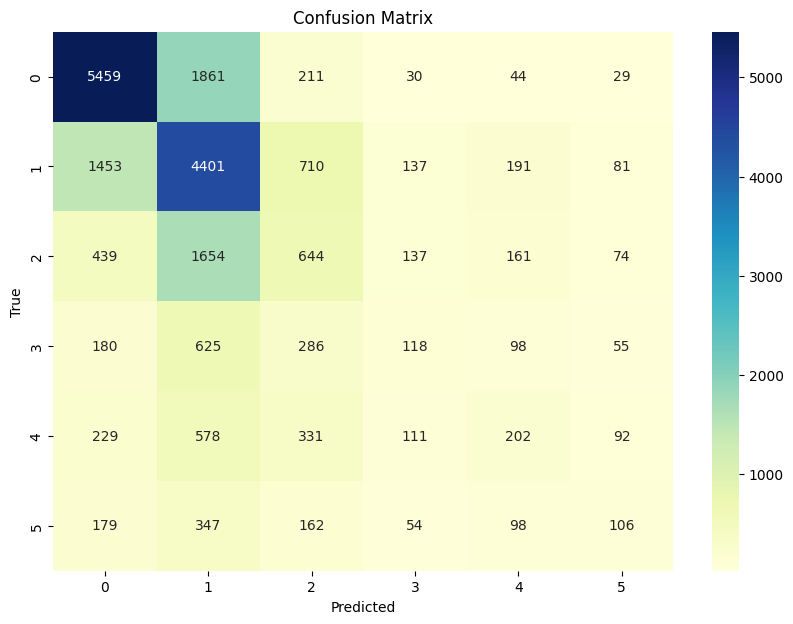

Precision (train):  0.78
Precision (test):  0.47
Recall (train):  0.77
Recall (test):  0.51
F1 Score (train):  0.76
F1 Score (test):  0.48


In [109]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [110]:
# Calculate Classification Report
classification_train = classification_report(y_train, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

Classification Report (train):                precision    recall  f1-score   support

           1       0.86      0.87      0.86     30534
           2       0.68      0.89      0.77     27891
           3       0.75      0.60      0.67     12436
           4       0.84      0.48      0.61      5447
           5       0.82      0.52      0.63      6175
           6       0.87      0.53      0.66      3783

    accuracy                           0.77     86266
   macro avg       0.80      0.65      0.70     86266
weighted avg       0.78      0.77      0.76     86266

Classification Report (test):                precision    recall  f1-score   support

           1       0.69      0.72      0.70      7634
           2       0.46      0.63      0.54      6973
           3       0.27      0.21      0.24      3109
           4       0.20      0.09      0.12      1362
           5       0.25      0.13      0.17      1543
           6       0.24      0.11      0.15       946

    accuracy  

#### Model 2: KNeighborsClassifier

##### GridSearchCV

param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

Best parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}

In [70]:
# Instantiate and train KNeighborsClassifier
#model_2 = KNeighborsClassifier(**grid_search.best_params_) # Get best parameters from grid search
model_2 = KNeighborsClassifier(n_neighbors=7, weights='uniform', metric='manhattan')
model_2.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=7)

In [ ]:
# Definition of hyperparameters
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# GridSearchCV initiation
grid_search = GridSearchCV(model_2, param_grid, cv=5)

# Search for best parameters
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

In [71]:
y_pred_train = model_2.predict(X_train)
y_pred_test = model_2.predict(X_test)

In [72]:
# Save the model
dump(model_2, 'models/model_2.joblib')

['models/model_2.joblib']

In [81]:
# Load model
model_2 = load('models/model_2.joblib')

##### Evaluation

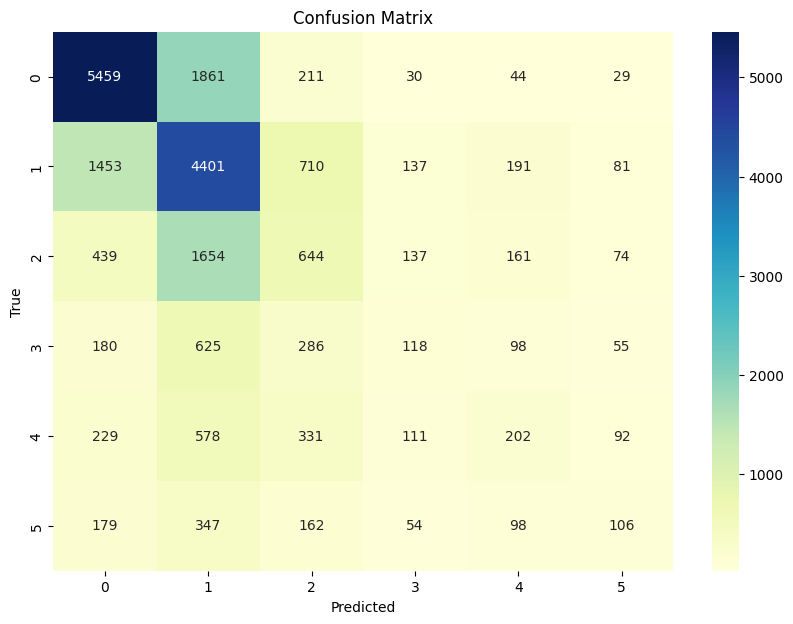

Precision (train):  0.78
Precision (test):  0.47
Recall (train):  0.77
Recall (test):  0.51
F1 Score (train):  0.76
F1 Score (test):  0.48


In [111]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [ ]:
# Calculate Classification Report
classification_train = classification_report(y_train, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

#### Model 3: Decision Tree Classifier

In [ ]:
# Instantiate and train decision tree classifier on gini
#model_3 = DecisionTreeClassifier(criterion='gini', random_state=RSEED)
#model_3.fit(X_train, y_train)

##### RandomizedSearchCV

In [ ]:
# Define the parameter distribution for random search
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': uniform(0, 1)
}

# Create a base model
dt = DecisionTreeClassifier(random_state=RSEED)

# Create a custom scorer (you can change this to other metrics if needed)
scorer = make_scorer(accuracy_score)

# Instantiate RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=100,  # number of parameter settings that are sampled
    cv=5,  # number of cross-validation folds
    scoring=scorer,
    random_state=RSEED,
    n_jobs=-1  # use all available cores
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Get the best model
model_3 = random_search.best_estimator_

In [ ]:
y_pred_train = model_3.predict(X_train)
y_pred_test = model_3.predict(X_test)

In [ ]:
# Save the model
dump(model_3, 'models/model_3.joblib')

In [82]:
# Load model
model_3 = load('models/model_3.joblib')

##### Evaluation

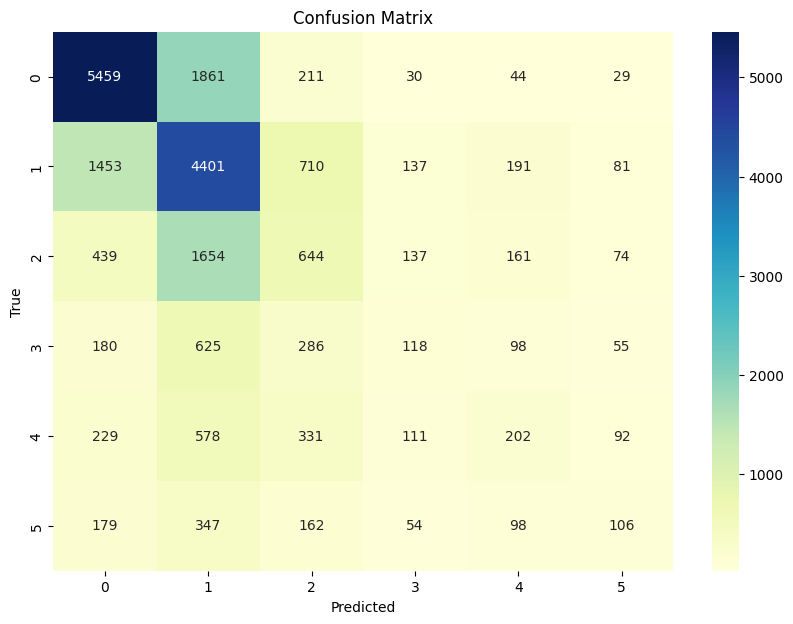

Precision (train):  0.78
Precision (test):  0.47
Recall (train):  0.77
Recall (test):  0.51
F1 Score (train):  0.76
F1 Score (test):  0.48


In [112]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [ ]:
# Calculate Classification Report
classification_train = classification_report(y_train, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

#### Model 4: Random Forest Classifier

In [ ]:
# Instantiate and train Random Forest Classifier model
model_4 = RandomForestClassifier(random_state=RSEED, max_features = 'sqrt', n_jobs=-1, verbose = 1)
model_4.fit(X_train, y_train)

##### GridSearchCV

In [ ]:
# Definition of hyperparameters
param_grid = {
    'n_estimators': [100, 200, 700],
    'max_depth': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2']
}

# GridSearchCV initiation
grid_search = GridSearchCV(model_4, param_grid, cv=5)

# Search for best parameters
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

param_grid = {
    'n_estimators': [100, 200, 700],
    'max_depth': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2']
}

Best parameters: 

In [ ]:
y_pred_train = model_4.predict(X_train)
y_pred_test = model_4.predict(X_test)

In [ ]:
# Save the model
dump(model_4, 'models/model_4.joblib')

In [83]:
# Load model
model_4 = load('models/model_4.joblib')

##### Evaluation

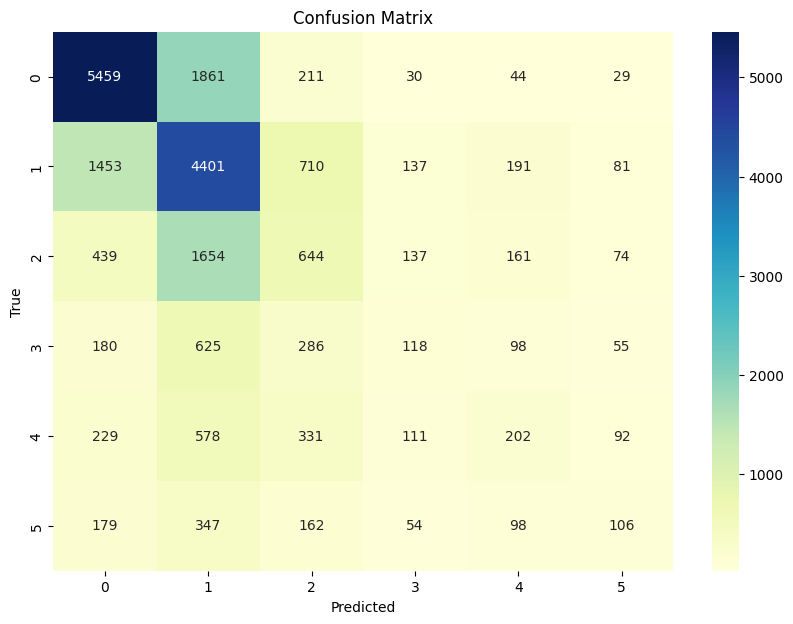

Precision (train):  0.78
Precision (test):  0.47
Recall (train):  0.77
Recall (test):  0.51
F1 Score (train):  0.76
F1 Score (test):  0.48


In [113]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [ ]:
# Calculate Classification Report
classification_train = classification_report(y_train, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

#### Model 5: XGBClassifier

In [74]:
# Instantiate and train XGBoost Classifier model
model_5 = XGBClassifier(random_state=RSEED)
model_5.fit(X_train, y_train - 1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [75]:
y_pred_train = model_5.predict(X_train)
y_pred_test = model_5.predict(X_test)

In [76]:
# Save the model
dump(model_5, 'models/model_5.joblib')

['models/model_5.joblib']

In [84]:
# Load model
model_5 = load('models/model_5.joblib')

##### Evaluation

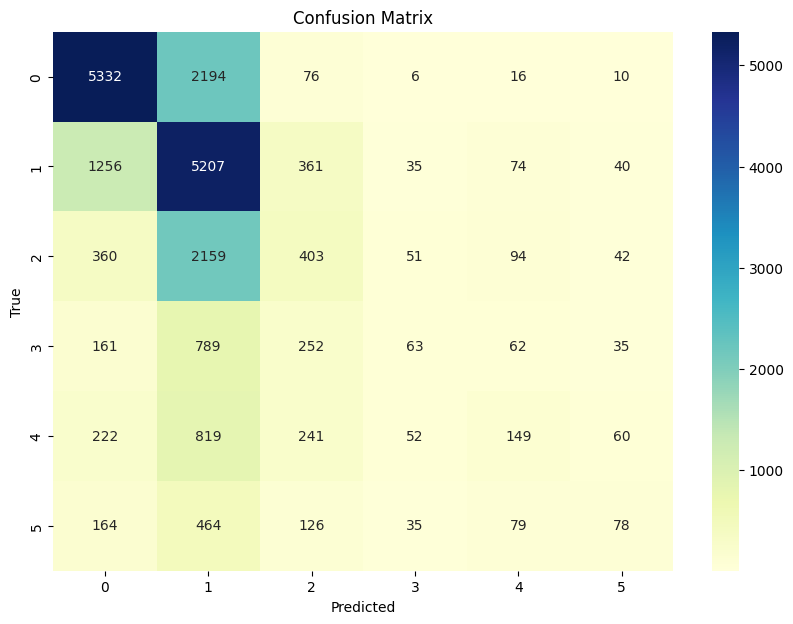

Precision (train):  0.56
Precision (test):  0.49
Recall (train):  0.56
Recall (test):  0.52
F1 Score (train):  0.52
F1 Score (test):  0.48


In [77]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test - 1, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train - 1, y_pred_train, average='weighted')
precision_test = precision_score(y_test - 1, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train - 1, y_pred_train, average='weighted')
recall_test = recall_score(y_test - 1, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train - 1, y_pred_train, average='weighted')
f1_test = f1_score(y_test - 1, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [78]:
# Calculate Classification Report
classification_train = classification_report(y_train, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

Classification Report (train):                precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.18      0.27      0.21     30534
           2       0.19      0.04      0.07     27891
           3       0.17      0.01      0.03     12436
           4       0.12      0.05      0.07      5447
           5       0.17      0.03      0.05      6175
           6       0.00      0.00      0.00      3783

    accuracy                           0.12     86266
   macro avg       0.12      0.06      0.06     86266
weighted avg       0.17      0.12      0.11     86266

Classification Report (test):                precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.19      0.29      0.23      7634
           2       0.25      0.05      0.09      6973
           3       0.21      0.02      0.03      3109
           4       0.13      0.05      0.07      1362
           5   

#### Model 6: Ada Boost

In [ ]:
# Instantiate and train Ada Boost classifier
#model_6 = AdaBoostClassifier(random_state=RSEED)
#model_6.fit(X_train, y_train)

##### RandomizedSearchCV

In [ ]:
# Define the parameter distribution for random search
param_dist = {
    'n_estimators': randint(50, 100),  # Reduced upper bound
    'learning_rate': uniform(0.01, 0.5),  # Reduced upper bound
    'base_estimator__max_depth': randint(1, 5),  # Reduced upper bound
    'base_estimator__min_samples_split': randint(2, 10),  # Reduced upper bound
    'base_estimator__min_samples_leaf': randint(1, 10),  # Reduced upper bound
    'algorithm': ['SAMME', 'SAMME.R']
}

# Create a base model
base_estimator = DecisionTreeClassifier(random_state=RSEED)
ada = AdaBoostClassifier(base_estimator=base_estimator, random_state=RSEED)

# Create a custom scorer (you can change this to other metrics if needed)
scorer = make_scorer(f1_score)

# Instantiate RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=ada,
    param_distributions=param_dist,
    n_iter=50,  # Reduced number of iterations
    cv=3,  # Reduced number of cross-validation folds
    scoring=scorer,
    random_state=RSEED,
    n_jobs=-1  # use all available cores
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Get the best model
model_6 = random_search.best_estimator_

In [ ]:
y_pred_train = model_6.predict(X_train)
y_pred_test = model_6.predict(X_test)

In [ ]:
# Save the model
dump(model_6, 'models/model_6.joblib')

In [85]:
# Load model
model_6 = load('models/model_6.joblib')

##### Evaluation

In [ ]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [ ]:
# Calculate Classification Report
classification_train = classification_report(y_train, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

#### Model 7: Bagging

In [ ]:
# Instantiate and train Bagging Classifier with base model DecisionTreeClassifier
#model_7 = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=RSEED)
#model_7.fit(X_train, y_train)

##### RandomizedSearchCV

In [ ]:
# Define the parameter distribution for random search
param_dist = {
    'n_estimators': randint(10, 200),
    'max_samples': uniform(0.5, 1.0),
    'max_features': uniform(0.1, 1.0),  
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'base_estimator__max_depth': randint(1, 20),
    'base_estimator__min_samples_split': randint(2, 20),
    'base_estimator__min_samples_leaf': randint(1, 20)
}

# Create a base model
base_estimator = DecisionTreeClassifier(random_state=RSEED)
bagging = BaggingClassifier(base_estimator=base_estimator, random_state=RSEED)

# Create a custom scorer (you can change this to other metrics if needed)
scorer = make_scorer(f1_score, average='weighted')  # Specify average for multi-class

# Instantiate RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=bagging,
    param_distributions=param_dist,
    n_iter=100,  # number of parameter settings that are sampled
    cv=5,  # number of cross-validation folds
    scoring=scorer,
    random_state=RSEED,
    n_jobs=-1  # use all available cores
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Get the best model
model_7 = random_search.best_estimator_

In [ ]:
y_pred_train = model_7.predict(X_train)
y_pred_test = model_7.predict(X_test)

In [ ]:
# Save the model
dump(model_7, 'models/model_7.joblib')

In [86]:
# Load model
model_7 = load('models/model_7.joblib')

##### Evaluation

In [ ]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [ ]:
# Calculate Classification Report
classification_train = classification_report(y_train, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

#### Model 8: Extra Trees

In [ ]:
# Instantiate and train extreme random tree regressor on poisson/squared_error/absolute_error/friedman_mse
model_8 = ExtraTreesClassifier(random_state=RSEED, max_features='sqrt', n_jobs=-1, verbose=1, n_estimators=200)
model_8.fit(X_train, y_train)

##### RandomizedSearchCV

In [ ]:
# # Define the parameter distribution for random search
# param_dist = {
#     #'class_weight': ['balanced', 'balanced_subsample'],  # takes count within classes into account 
#     'max_depth': randint(50, 10000),
#     'min_samples_leaf': randint(10, 100),
#     #'min_samples_split': randint(2,10000),
#     'n_estimators': randint(200, 5000),
#     'criterion': ['gini', 'entropy', 'log_loss']
# }

# # Create a base model
# XTC = ExtraTreesClassifier(random_state=RSEED, class_weight='balanced')

# # Create a custom scorer (you can change this to other metrics if needed)
# scorer = make_scorer(f1_score)

# # Instantiate RandomizedSearchCV object
# random_search = RandomizedSearchCV(
#     estimator=XTC,
#     param_distributions=param_dist,
#     n_iter=50,  # Reduced number of iterations
#     cv=3,  # Reduced number of cross-validation folds
#     scoring=scorer,
#     random_state=RSEED,
#     n_jobs=-1  # use all available cores
# )

# # Fit RandomizedSearchCV
# random_search.fit(X_train, y_train)

# # Print the best parameters and score
# print("Best parameters:", random_search.best_params_)
# print("Best cross-validation score:", random_search.best_score_)

# # Get the best model
# model_8_rscv = random_search.best_estimator_

##### GridSearchCV

In [ ]:
# # Defining parameter grid
# param_grid = {
#     'max_features': ['sqrt', 'log2', None],
#     'min_samples_leaf': [10, 100, 200, 500, 1000, 10000],
#     'n_estimators': [100, 500, 1000, 5000]
# }
    
# # Create a base model
# XTC = ExtraTreesClassifier(random_state=RSEED) #, class_weight='balanced')
    
# # Create a custom scorer (you can change this to other metrics if needed)
# scorer = make_scorer(f1_score)
    
# # Instantiate gridsearch and define the metric to optimize 
# grid_search = GridSearchCV(
#     estimator=XTC, 
#     param_grid=param_grid,
#     scoring=scorer,
#     cv=3,  # Reduced number of cross-validation folds 
#     verbose=5, 
#     n_jobs=-1 # use all available cores
# )

# # Fit GridSearchCV
# grid_search.fit(X_train, y_train)

# # Print the best parameters and score
# print("Best parameters:", grid_search.best_params_)
# print("Best cross-validation score:", grid_search.best_score_)

# # Get the best model
# model_8_gscv = grid_search.best_estimator_

In [67]:
y_pred_train = model_8.predict(X_train)
y_pred_test = model_8.predict(X_test)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    1.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.3s finished


In [ ]:
# Save the model
dump(model_8, 'models/model_8.joblib')

In [87]:
# Load model
model_8 = load('models/model_8.joblib')

##### Evaluation

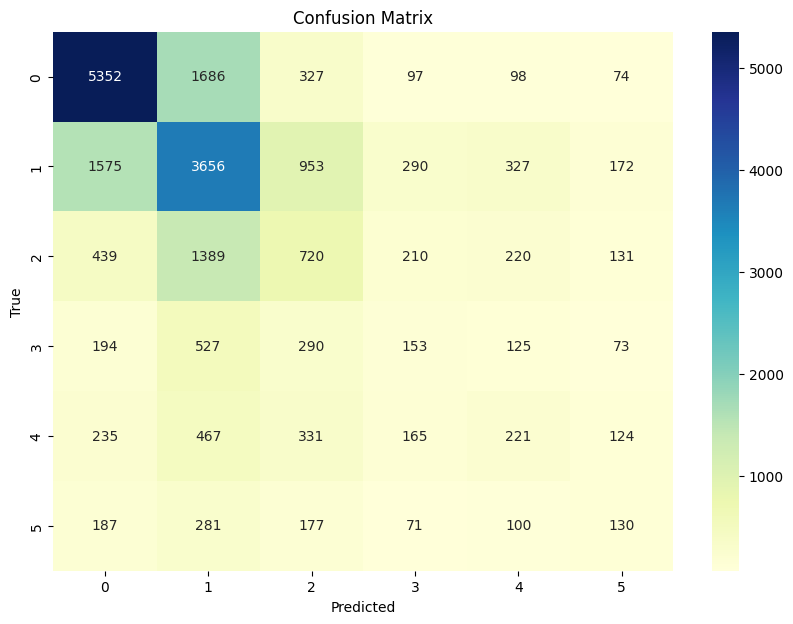

Precision (train):  0.8
Precision (test):  0.45
Recall (train):  0.8
Recall (test):  0.47
F1 Score (train):  0.8
F1 Score (test):  0.46


In [65]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [69]:
# Calculate Classification Report
classification_train = classification_report(y_train, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

Classification Report (train):                precision    recall  f1-score   support

           1       0.82      0.96      0.88     30534
           2       0.77      0.84      0.80     27891
           3       0.79      0.65      0.71     12436
           4       0.83      0.57      0.68      5447
           5       0.89      0.55      0.68      6175
           6       0.94      0.58      0.72      3783

    accuracy                           0.80     86266
   macro avg       0.84      0.69      0.74     86266
weighted avg       0.81      0.80      0.80     86266

Classification Report (test):                precision    recall  f1-score   support

           1       0.64      0.73      0.68      7634
           2       0.45      0.50      0.48      6973
           3       0.26      0.22      0.24      3109
           4       0.16      0.11      0.13      1362
           5       0.20      0.13      0.16      1543
           6       0.17      0.11      0.13       946

    accuracy  

#### Model 9: Gradient Boosting Classifier

In [ ]:
# Instantiate and train Gradient Boosting Classifier
model_9 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1.0, max_features='sqrt', random_state=RSEED)
model_9.fit(X_train, y_train)

##### RandomizedSearchCV¶

In [ ]:
# # Define the parameter distribution for random search
# param_dist = {
#     'n_estimators': randint(100, 10000),
#     'learning_rate': uniform(0.05, 1),
#     'loss': ['log_loss', 'exponential']
    
#     'class_weight': ['balanced', 'balanced_subsample'],  # takes count within classes into account 
#     'max_depth': randint(10, 10000),
#     'min_samples_leaf': randint(10, 50000),
#     #'min_samples_split': randint(2,10000),
#     'n_estimators': randint(100, 10000),
#     'criterion': ['gini', 'entropy', 'log_loss']
# }

# # Create a base model
# #base_estimator = DecisionTreeClassifier(random_state=RSEED)
# GBC = ExtraTreesClassifier(random_state=RSEED)

# # Create a custom scorer (you can change this to other metrics if needed)
# scorer = make_scorer(f1_score)

# # Instantiate RandomizedSearchCV object
# random_search = RandomizedSearchCV(
#     estimator=GBC,
#     param_distributions=param_dist,
#     n_iter=50,  # Reduced number of iterations
#     cv=3,  # Reduced number of cross-validation folds
#     scoring=scorer,
#     random_state=RSEED,
#     n_jobs=-1  # use all available cores
# )

# # Fit RandomizedSearchCV
# random_search.fit(X_train, y_train)

# # Print the best parameters and score
# print("Best parameters:", random_search.best_params_)
# print("Best cross-validation score:", random_search.best_score_)

# # Get the best model
# model_9 = random_search.best_estimator_

In [ ]:
y_pred_train = model_9.predict(X_train)
y_pred_test = model_9.predict(X_test)

In [ ]:
# Save the model
dump(model_9, 'models/model_9.joblib')

In [88]:
# Load model
model_9 = load('models/model_9.joblib')

##### Evaluation

In [ ]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [ ]:
# Calculate Classification Report
classification_train = classification_report(y_train, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

#### Model 10: Stacking

In [93]:
# Hyperparameter grid
estimators = [
#    ('sgd', model_1),
    ('knn', model_2),
    ('dt', model_3),
    ('rf', model_4),
    ('xgb', model_5),
    ('ada', model_6),
    ('bag', model_7),
    ('extra', model_8),
    ('grboo', model_9),
    ]

# Instantiate and train Stacking Classifier/Regressor model
model_10 = StackingClassifier(estimators=estimators, final_estimator=DecisionTreeClassifier(), cv=5, stack_method='predict_proba')
model_10.fit(X_train, y_train).score(X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   21.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent worke

0.4178142532572912

In [95]:
y_pred_train = model_10.predict(X_train)
y_pred_test = model_10.predict(X_test)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    1.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.2s finished


In [94]:
# Save the model
dump(model_10, 'models/model_10.joblib')

['models/model_10.joblib']

In [ ]:
# Load model
model_10 = load('models/model_10.joblib')

##### Evaluation

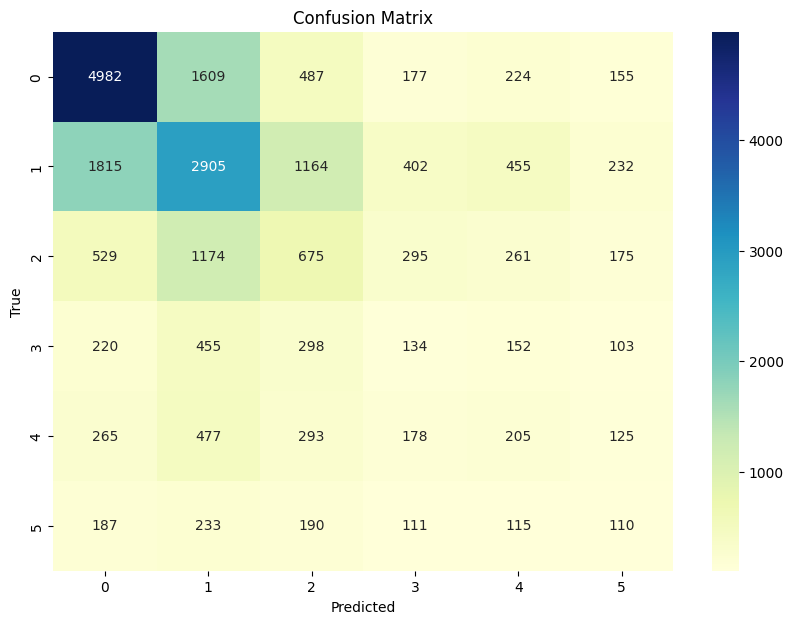

Precision (train):  0.45
Precision (test):  0.41
Recall (train):  0.45
Recall (test):  0.42
F1 Score (train):  0.45
F1 Score (test):  0.41


In [96]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [97]:
# Calculate Classification Report
classification_train = classification_report(y_train, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

Classification Report (train):                precision    recall  f1-score   support

           1       0.66      0.69      0.67     30534
           2       0.46      0.46      0.46     27891
           3       0.25      0.25      0.25     12436
           4       0.16      0.15      0.16      5447
           5       0.16      0.15      0.16      6175
           6       0.17      0.16      0.16      3783

    accuracy                           0.45     86266
   macro avg       0.31      0.31      0.31     86266
weighted avg       0.45      0.45      0.45     86266

Classification Report (test):                precision    recall  f1-score   support

           1       0.62      0.65      0.64      7634
           2       0.42      0.42      0.42      6973
           3       0.22      0.22      0.22      3109
           4       0.10      0.10      0.10      1362
           5       0.15      0.13      0.14      1543
           6       0.12      0.12      0.12       946

    accuracy  

#### Model 11: Max Voting Classifier

In [104]:
# Instantiate models
estimators = [
#    ('sgd', model_1),
    ('knn', model_2),
    ('dt', model_3),
    ('rf', model_4),
    ('xgb', model_5),
    ('ada', model_6),
    ('bag', model_7),
    ('extra', model_8),
    ('grboo', model_9),
    ]

# Instantiate and train Voting Classifier model
model_11 = VotingClassifier(estimators=estimators, voting='soft')
model_11.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   20.6s finished


VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=7)),
                             ('dt',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=19,
                                                     max_features=0.7276963431316488,
                                                     min_samples_split=11,
                                                     random_state=0)),
                             ('rf',
                              RandomForestClassifier(n_jobs=-1, random_state=0,
                                                     verbose=1)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=...
                                                                                      min_samples_leaf=5,
                                                                                      min_samples_split=9,
                                                                                      random_state=0),
                                                bootstrap=False,
                                                bootstrap_features=True,
                                                max_features=0.985962269002118,
                                                max_samples=0.8518705609272555,
                                                n_estimators=58,
                                                random_state=0)),
                             ('extra',
                              ExtraTreesClassifier(n_estimators=200, n_jobs=-1,
                                                   random_state=0, verbose=1)),
                             ('grboo',
                              GradientBoostingClassifier(max_features='sqrt',
                                                         random_state=0))],
                 voting='soft')

In [105]:
y_pred_train = model_11.predict(X_train)
y_pred_test = model_11.predict(X_test)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.8s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    2.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.3s finished


In [106]:
# Save the model
dump(model_11, 'models/model_11.joblib')

['models/model_11.joblib']

In [103]:
# Load model
model_11 = load('models/model_11.joblib')

KeyboardInterrupt: 

##### Evaluation

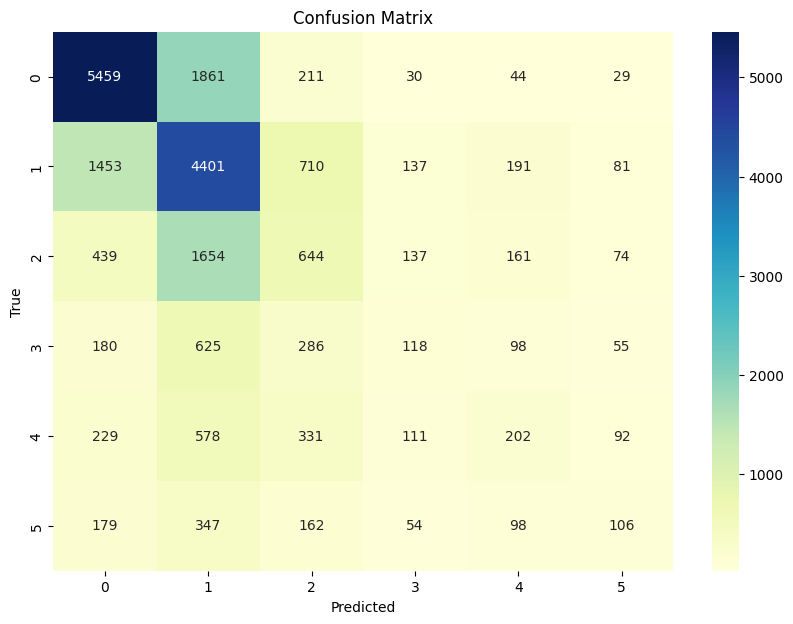

Precision (train):  0.78
Precision (test):  0.47
Recall (train):  0.77
Recall (test):  0.51
F1 Score (train):  0.76
F1 Score (test):  0.48


In [107]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [108]:
# Calculate Classification Report
classification_train = classification_report(y_train, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

Classification Report (train):                precision    recall  f1-score   support

           1       0.86      0.87      0.86     30534
           2       0.68      0.89      0.77     27891
           3       0.75      0.60      0.67     12436
           4       0.84      0.48      0.61      5447
           5       0.82      0.52      0.63      6175
           6       0.87      0.53      0.66      3783

    accuracy                           0.77     86266
   macro avg       0.80      0.65      0.70     86266
weighted avg       0.78      0.77      0.76     86266

Classification Report (test):                precision    recall  f1-score   support

           1       0.69      0.72      0.70      7634
           2       0.46      0.63      0.54      6973
           3       0.27      0.21      0.24      3109
           4       0.20      0.09      0.12      1362
           5       0.25      0.13      0.17      1543
           6       0.24      0.11      0.15       946

    accuracy  

## Evaluation

## Validation

## Packaging